In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import multivariate_normal, invwishart
import pandas as pd

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=10,6

In [4]:
total_data = 500
total_iterations = 200
k = 2
A = 0.4

In [5]:
# data generation
params = {0: {"mu": [1, 2], "cov": [[1, 0], [0, 1]], "pi": 0.4},
          1: {"mu": [-1, 4], "cov": [[1, 0], [0, 1]], "pi": 0.6}}

data_points_color = []
data_points = []
used_z = []

cluster0 = multivariate_normal(mean=params[0]["mu"], cov=params[0]["cov"])
cluster1 = multivariate_normal(mean=params[1]["mu"], cov=params[1]["cov"])

clusters = [cluster0, cluster1]

for i in range(total_data):
    cluster = np.random.choice(2, 1, p=[params[0]["pi"], params[1]["pi"]]).item()
    used_z.append(cluster)
    dist = clusters[cluster]
    values = dist.rvs().tolist()
    data_points_color.append(values + [cluster])
    data_points.append(values)
    

colors = ["r" if used_z[i] == 0 else "b" for i in range(len(used_z))]

(-4.8996789007703345, 4.197183113562691, -1.1807568948430902, 8.29253354103811)

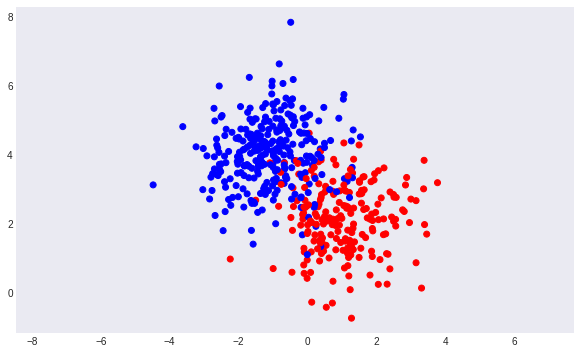

In [6]:
plt.scatter(np.array(data_points_color)[:, 0], np.array(data_points_color)[:, 1], color=colors)
plt.axis('equal')

In [7]:
z = []
mus = {0: [0, 0], 1: [1, 1]}
sigmas = {0: [[1, 0], [0, 1]], 1: [[1, 0], [0, 1]]}
# data_points = np.array(data_points)
total_clusters = k
likelihoods = []

# randomly assign z
for i in range(total_data):
    z.append(np.random.choice(total_clusters, 1, p=[1/total_clusters for _ in range(total_clusters)]).item())

In [8]:
np.sum(np.array(z)==0)

233

In [9]:
phi = np.array([[1, 0], [0, 1]])
nu = 4
lamda = 1
mu0 = np.array([4, 5])

In [10]:
def pdf(x, mu, cov):
    """
    x: dx1 vector
    mu: dx1 vector
    cov: dxd matrix
    """
#     print(f"x: {x}")
    prob = multivariate_normal(mean=mu, cov=cov, seed=seed).pdf(x)
    
    return prob

In [11]:
def get_mu_sigma1(data, phi, nu, mu0, lamda):
    n = data.shape[0]
#     print(type(data), data.shape)
#     data = np.array(data)
    x_bar = np.mean(data, axis=0)
    
#     print(f"shapes=> data: {data.shape}, phi: {phi.shape}, mu0: {mu0.shape}, x_bar: {x_bar.shape}")
    
    new_mu0 = (lamda * mu0 + n * x_bar)/(lamda + n)
    new_lamda = lamda + n
    new_nu = nu + n
    S = np.sum(np.dot(data-x_bar, (data-x_bar).T))
    
    new_phi = phi + S + ((lamda * n)/(lamda + n)) * np.dot(x_bar - mu0, (x_bar - mu0).T)
    
    cov = invwishart(df=new_nu, scale=new_phi).rvs(1)
    mean = multivariate_normal(new_mu0, cov/new_lamda).rvs(1)
    
    return mean, cov

In [12]:
def get_mu_sigma(data, phi, nu, mu0, lamda):
    n = data.shape[0]
#     print(type(data), data.shape)
#     data = np.array(data)
    x_bar = np.mean(data, axis=0)
    
#     print(f"shapes=> data: {data.shape}, phi: {phi.shape}, mu0: {mu0.shape}, x_bar: {x_bar.shape}")
    
    new_mu0 = (lamda * mu0 + n * x_bar)/(lamda + n)
    new_lamda = lamda + n
    new_nu = nu + n
    
    diff = data - x_bar
    S = diff.T @ diff
    
    new_phi = phi + S + ((lamda * n)/(lamda + n)) * np.dot(x_bar - mu0, (x_bar - mu0).T)
    
    cov = invwishart(df=new_nu, scale=new_phi).rvs(1)
    mean = multivariate_normal(new_mu0, cov/new_lamda).rvs(1)
    
    return mean, cov

In [13]:
for step in range(total_iterations):
    print("running iteration ", step+1)
    for idx, xi in enumerate(data_points):
        # remove data point xi, zi
        xi, zi = xi, z[idx] 
        req_data_points = np.array(data_points[0:idx] + data_points[idx+1:])
        req_zi = np.array(z[0:idx] + z[idx+1:])
        
#         req_data = np.array(data_points)
#         req_z = np.array(z)
        
        probs = np.zeros(total_clusters)
        for cluster in range(total_clusters):
            
            req_data = req_data_points[np.array(req_zi) == cluster]
            
            # get mu and sigma
            mean, cov = get_mu_sigma(req_data, phi, nu, mu0, lamda)
            mus[cluster] = mean
            sigmas[cluster] = cov
            probs[cluster] = pdf(xi, mean, cov)
            
            
        # sample zi
        new_probs = np.zeros(total_clusters)
        counts = Counter(z)
        
        for cluster in range(total_clusters):
            prob = ((counts[cluster] + A/total_clusters)/(total_data - 1 + A)) * probs[cluster]
            new_probs[cluster] = prob
        
        # normalize
        prob_sum = np.sum(new_probs)
        final_probs = new_probs/prob_sum
        
        if np.sum(np.isnan(final_probs)) >= 1:
#             print("========", final_probs)
            final_probs = [1/total_clusters for _ in range(total_clusters)]
        
        new_z = np.random.choice(total_clusters, 1, p=final_probs).item()
        z[idx] = new_z

    # compute likelihood
    l = []
#     mus = {0: np.array([0, 0]), 1: np.array([1, 1])}
#     sigmas = {0: np.array([[1, 0], [0, 1]]), 1: np.array([[1, 0], [0, 1]])}
    
    for idx, d in enumerate(data_points):
        probs = np.zeros(total_clusters)

        for cluster in range(total_clusters):
            req = np.array(z) == cluster
            req_data = np.array(data_points)[req].tolist()
            
#             req_data = np.array(data_points)
#             req_z = np.array(z)

            # get mu and sigma
#             mean, cov = get_mu_sigma(req_data, phi, nu, mu0, lamda)
            mean, cov = mus[cluster], sigmas[cluster]
#             mus[cluster] = mean
#             sigmas[cluster] = cov
            probs[cluster] = pdf(d, mean, cov)
        
        # sample zi
        new_probs = np.zeros(total_clusters)
        counts = Counter(z)
        
        for cluster in range(total_clusters):
            prob = ((counts[cluster] + A/total_clusters)/(total_data - 1 + A)) * probs[cluster]
            new_probs[cluster] = prob

        pi_0 = np.sum(z[idx] == 0)/total_data
        pi_1 = np.sum(z[idx] == 1)/total_data
        
        # normalize
        prob_sum = np.sum(new_probs)
        final_probs = new_probs/prob_sum
        
#         print(f"====", new_probs)
        
        val = pi_0 * new_probs[0] + pi_1 * new_probs[1]        
        
        l.append(np.log(val))

    likelihoods.append(np.sum(l))
    
    for k in range(total_clusters):
        print(f"cluster {k}: mean: {mus[k]}, cov: {sigmas[k]}")
    
    print("-------------")

running iteration  1
cluster 0: mean: [-0.41966063  3.42085059], cov: [[ 2.10821443 -1.0478917 ]
 [-1.0478917   1.89797974]]
cluster 1: mean: [-0.29436216  3.30151242], cov: [[ 2.00908464 -0.74691805]
 [-0.74691805  2.22214302]]
-------------
running iteration  2
cluster 0: mean: [-0.15523515  3.46813741], cov: [[ 2.0750625 -0.8782426]
 [-0.8782426  2.0693379]]
cluster 1: mean: [-0.11022492  3.23905515], cov: [[ 2.11433429 -0.88018263]
 [-0.88018263  1.79015468]]
-------------
running iteration  3
cluster 0: mean: [-0.44386225  3.27687944], cov: [[ 1.65266788 -0.53901168]
 [-0.53901168  1.86144577]]
cluster 1: mean: [0.05288499 3.19005479], cov: [[ 2.19728624 -0.7879012 ]
 [-0.7879012   1.57438104]]
-------------
running iteration  4
cluster 0: mean: [-0.55869094  3.45384702], cov: [[ 1.54296453 -0.68685179]
 [-0.68685179  2.43817914]]
cluster 1: mean: [-0.03901262  3.2701954 ], cov: [[ 2.39774085 -1.0758799 ]
 [-1.0758799   1.80785444]]
-------------
running iteration  5
cluster 0: me

cluster 0: mean: [1.05140023 2.13254685], cov: [[0.95725645 0.07226957]
 [0.07226957 1.00664397]]
cluster 1: mean: [-1.12476398  4.02553142], cov: [[0.98867836 0.08180631]
 [0.08180631 0.83161138]]
-------------
running iteration  37
cluster 0: mean: [0.92761873 2.12504924], cov: [[1.2197811  0.15354309]
 [0.15354309 0.95857069]]
cluster 1: mean: [-1.14077512  4.14874077], cov: [[0.92345508 0.21685127]
 [0.21685127 1.03829618]]
-------------
running iteration  38
cluster 0: mean: [0.97280898 2.35695956], cov: [[0.90624581 0.02846946]
 [0.02846946 1.16087221]]
cluster 1: mean: [-1.18150739  4.20570548], cov: [[0.87431715 0.22227325]
 [0.22227325 0.9162396 ]]
-------------
running iteration  39
cluster 0: mean: [1.0981419  2.36117654], cov: [[0.98652662 0.11909139]
 [0.11909139 1.10699283]]
cluster 1: mean: [-1.22574683  4.24757585], cov: [[0.87598075 0.32204394]
 [0.32204394 0.9975961 ]]
-------------
running iteration  40
cluster 0: mean: [0.94865772 2.18019671], cov: [[ 1.42490838 -0.

cluster 0: mean: [0.9396078  2.30277022], cov: [[ 1.08248947 -0.0278891 ]
 [-0.0278891   1.26895906]]
cluster 1: mean: [-1.20413717  4.13675773], cov: [[0.82507684 0.19234433]
 [0.19234433 0.92623654]]
-------------
running iteration  72
cluster 0: mean: [0.89712664 2.28339364], cov: [[1.39924221 0.06671994]
 [0.06671994 1.13699236]]
cluster 1: mean: [-1.31778051  4.11365158], cov: [[0.95630851 0.37140636]
 [0.37140636 0.84506812]]
-------------
running iteration  73
cluster 0: mean: [0.81687216 2.32751136], cov: [[ 1.53982694 -0.0764067 ]
 [-0.0764067   1.26701535]]
cluster 1: mean: [-1.24849423  4.29764299], cov: [[0.91976095 0.31190144]
 [0.31190144 0.83775   ]]
-------------
running iteration  74
cluster 0: mean: [0.85003772 2.43317124], cov: [[ 1.28009402 -0.22453594]
 [-0.22453594  1.20111095]]
cluster 1: mean: [-1.24774838  4.15330127], cov: [[0.79719424 0.26581636]
 [0.26581636 0.81711784]]
-------------
running iteration  75
cluster 0: mean: [0.86648452 2.30672946], cov: [[0.9

cluster 0: mean: [1.127536  2.1135458], cov: [[1.26355396 0.3878711 ]
 [0.3878711  1.19054957]]
cluster 1: mean: [-0.97665123  3.85557404], cov: [[1.17195994 0.05383843]
 [0.05383843 1.08064228]]
-------------
running iteration  107
cluster 0: mean: [1.1942879  2.08126041], cov: [[0.90060209 0.23757251]
 [0.23757251 0.99367936]]
cluster 1: mean: [-1.09714247  4.01054612], cov: [[1.10967051 0.28496122]
 [0.28496122 0.92540107]]
-------------
running iteration  108
cluster 0: mean: [1.25681349 2.09344463], cov: [[1.06191798 0.29287217]
 [0.29287217 0.95344929]]
cluster 1: mean: [-1.13245806  4.03572577], cov: [[0.95033031 0.12405566]
 [0.12405566 0.94752488]]
-------------
running iteration  109
cluster 0: mean: [1.2098408  1.96091696], cov: [[1.02110946 0.26490821]
 [0.26490821 1.11258826]]
cluster 1: mean: [-1.08261763  3.8868209 ], cov: [[0.9309949  0.23914216]
 [0.23914216 1.02403899]]
-------------
running iteration  110
cluster 0: mean: [1.1567021  2.15866297], cov: [[0.96755561 0.

cluster 0: mean: [1.03659946 2.4252214 ], cov: [[1.2904667  0.04459062]
 [0.04459062 1.282466  ]]
cluster 1: mean: [-1.20545106  4.03035615], cov: [[0.876846   0.26645728]
 [0.26645728 0.94491235]]
-------------
running iteration  142
cluster 0: mean: [0.97143337 2.26872655], cov: [[1.11799162 0.06355062]
 [0.06355062 1.20570079]]
cluster 1: mean: [-1.15836084  4.10861795], cov: [[0.84534856 0.27527141]
 [0.27527141 0.9231051 ]]
-------------
running iteration  143
cluster 0: mean: [0.87974726 2.20888183], cov: [[ 1.06539338 -0.0340279 ]
 [-0.0340279   1.02371373]]
cluster 1: mean: [-1.07812034  4.23792267], cov: [[0.96782391 0.30448763]
 [0.30448763 0.87398685]]
-------------
running iteration  144
cluster 0: mean: [1.05180644 2.15511527], cov: [[1.04256105 0.10661298]
 [0.10661298 1.21226609]]
cluster 1: mean: [-1.08367573  4.03206443], cov: [[0.91803346 0.22502559]
 [0.22502559 0.97173382]]
-------------
running iteration  145
cluster 0: mean: [1.05740925 2.3540809 ], cov: [[ 1.2063

cluster 0: mean: [0.89789475 2.25881188], cov: [[1.23548076 0.02796589]
 [0.02796589 1.0980771 ]]
cluster 1: mean: [-1.21110646  4.05523606], cov: [[0.94155156 0.32595543]
 [0.32595543 0.92046133]]
-------------
running iteration  177
cluster 0: mean: [0.96443293 2.28675868], cov: [[1.19292993 0.08218244]
 [0.08218244 1.2756674 ]]
cluster 1: mean: [-1.20263548  4.17205894], cov: [[0.900307   0.26960256]
 [0.26960256 0.89153075]]
-------------
running iteration  178
cluster 0: mean: [0.89715907 2.36804785], cov: [[ 1.29572808 -0.12100435]
 [-0.12100435  1.39246477]]
cluster 1: mean: [-1.22713027  4.11853027], cov: [[0.94184576 0.32777314]
 [0.32777314 1.07986636]]
-------------
running iteration  179
cluster 0: mean: [0.97486667 2.29756449], cov: [[ 1.0308711  -0.02811233]
 [-0.02811233  1.20263001]]
cluster 1: mean: [-1.22428753  4.01973265], cov: [[0.8466924  0.34992883]
 [0.34992883 0.88907059]]
-------------
running iteration  180
cluster 0: mean: [1.00007328 2.18619575], cov: [[0.9

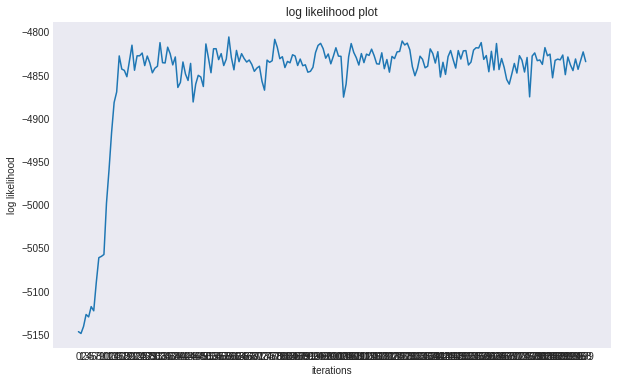

In [14]:
plt.xlabel("iterations")
plt.ylabel("log likelihood")
plt.xticks([i for i in range(total_iterations)])
plt.title("log likelihood plot")

plt.plot(likelihoods)

plt.show()

In [15]:
likelihoods

[-5146.418160630871,
 -5148.532054884235,
 -5140.438018052566,
 -5126.558579154971,
 -5129.385577813548,
 -5117.453697855543,
 -5122.306904139527,
 -5089.554382419972,
 -5060.825682138536,
 -5059.319750264871,
 -5057.139055332523,
 -4997.7854786726475,
 -4959.116166453552,
 -4916.112391754657,
 -4881.259837775856,
 -4869.012754976475,
 -4827.360589171139,
 -4842.604838160398,
 -4844.101324060217,
 -4851.440020163703,
 -4833.097264997536,
 -4814.938237950453,
 -4843.9508566716895,
 -4827.245096355653,
 -4827.221114145708,
 -4824.04831150809,
 -4838.559889257587,
 -4827.47853554369,
 -4835.482552108231,
 -4846.898275779492,
 -4841.552099788279,
 -4839.292398680447,
 -4811.985408977727,
 -4835.197993333209,
 -4835.508370169673,
 -4817.247937362237,
 -4824.951580084213,
 -4837.754092389958,
 -4828.558911502698,
 -4863.845867770704,
 -4858.042878825672,
 -4834.364734775196,
 -4848.409764967564,
 -4855.775698245934,
 -4836.027996170835,
 -4880.650406023644,
 -4860.068715087707,
 -4849.810566

In [16]:
# check cluster assignment
real = Counter(used_z)
predicted = Counter(z)

print(f"0 cluster: {real[0]}, {predicted[0]}")
print(f"1 cluster: {real[1]}, {predicted[1]}")

0 cluster: 209, 226
1 cluster: 291, 274


In [17]:
len(z)

500

In [18]:
# correct cluster predictions
np.sum(np.array(used_z) == np.array(z))

447

In [19]:
# real means
{k: params[k]["mu"] for k in range(total_clusters)}

{0: [1, 2], 1: [-1, 4]}

In [20]:
# predicted means
mus

{0: array([1.01988746, 2.20922402]), 1: array([-1.18447723,  4.24806189])}

In [21]:
# real cov
{k: params[k]["cov"] for k in range(total_clusters)}

{0: [[1, 0], [0, 1]], 1: [[1, 0], [0, 1]]}

In [22]:
# predicted cov
sigmas

{0: array([[1.22071349, 0.00264196],
        [0.00264196, 1.0735468 ]]),
 1: array([[0.89590422, 0.24426834],
        [0.24426834, 1.00254498]])}